In [2]:
import numpy as np
import scipy.stats as stats
import os, sys
import matplotlib.pyplot as plt

In [3]:
# av at each time step
def time_av(ts, xs):
    uts = np.unique(ts)
    return np.array([np.mean(xs[ts == t]) for t in uts])

# av at each radial distance for simulations with the protein
dgrid = np.linspace(0.0, 45.0, num=10)
def radial_time_av(xs, dgrid=dgrid):
    rad_tavs = []
    for i in range(1, len(dgrid)):
        ndxs = (xs[:,2] >= dgrid[i-1]) & (xs[:,2] >= dgrid[i])
        rad_tavs.append(time_av(xs[ndxs,0], xs[ndxs,1]))
    return rad_tavs

In [4]:
def block_average(xs, nblocks):
    split_xs = np.array_split(xs, nblocks)
    block_avs = list(map(np.nanmean, split_xs))
    return block_avs

def estimate_var(xs, minn=4, maxn=200, stride=1, chosen_n=None):
    nblocks = np.arange(minn, maxn, stride)
    estimated_vars = np.zeros(len(nblocks))
    for i, n in enumerate(nblocks):
        block_avs = block_average(xs, n)
        estimated_vars[i] = np.nanvar(block_avs)/(n-1)

    plt.scatter(nblocks, estimated_vars, marker='_')
    plt.errorbar(nblocks, estimated_vars, yerr=np.divide(estimated_vars*2**0.5, np.power(nblocks-1, 0.5)), alpha=0.5)
    plt.xlabel('Number of blocks')
    plt.ylabel('Estimated variance')
    if chosen_n is not None:
        plt.axvline(chosen_n, color='black', linestyle='--')
        plt.axhline(estimated_vars[nblocks == chosen_n][0], color='black', linestyle='--')
    plt.show()

The location of analysis directories must be specified.

In [5]:
# analysis directories for popc, apo CPTP, and C1P CPTP systems
popc_dir = ""
apo_dir = ""
c1p_dir = ""

# $N_{\rm CC}$

In [6]:
# load for POPC membrane w/o protein
f = os.path.join(popc_dir, "lip_mindcc_ncc_100_300ns_mem.txt")
popc = np.loadtxt(f, usecols=(0,3)) # time, ncc
avpopc = time_av(popc[:,0], popc[:,1])

# load for CPTP apo
fr = os.path.join(apo_dir, "lip_com_radial_dist_100_300ns_protmem.txt")
rs = np.loadtxt(fr, usecols=(4,))
f = os.path.join(apo_dir, "memlip_mindcc_ncc_100_300ns_protmem.txt")
apo = np.loadtxt(f, usecols=(0,4))
apo = np.c_[apo,rs] # time, ncc, radial dist
apos = radial_time_av(apo)

# load for CPTP C1P-bound
fr = os.path.join(c1p_dir, "lip_com_radial_dist_100_300ns_protmem.txt")
rs = np.loadtxt(fr, usecols=(4,))
f = os.path.join(c1p_dir, "memlip_mindcc_ncc_100_300ns_protmem.txt")
c1p = np.loadtxt(f, usecols=(0,4))
c1p = np.c_[c1p,rs] # time, ncc, radial dist
c1ps = radial_time_av(c1p)

## POPC membrane

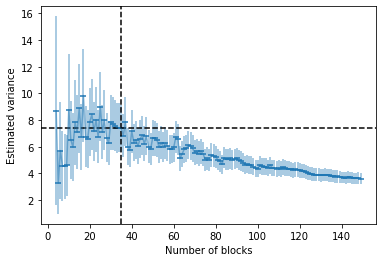

In [8]:
n = 35
estimate_var(avpopc, chosen_n=n, maxn=150)
popc_samples = block_average(avpopc, n)

## apo CPTP

5.0


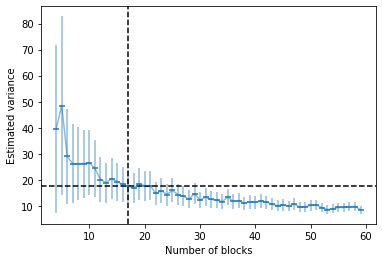

10.0


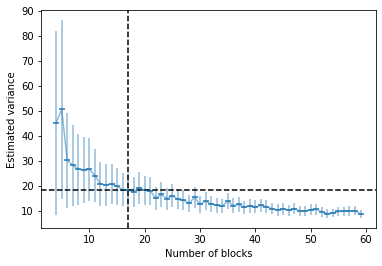

15.0


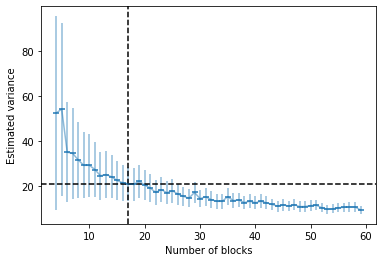

20.0


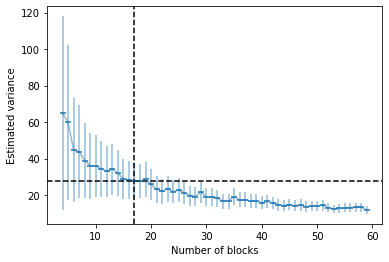

25.0


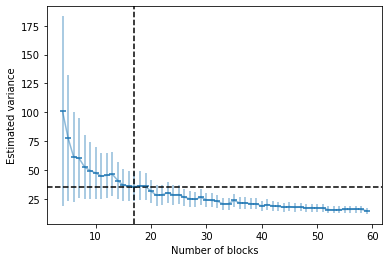

30.0


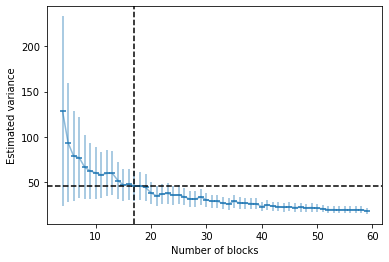

35.0


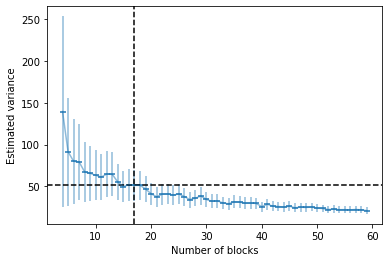

40.0


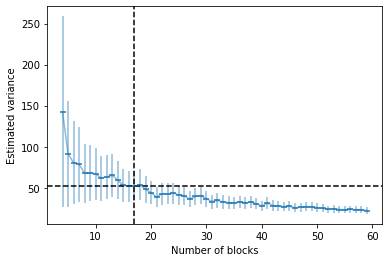

45.0


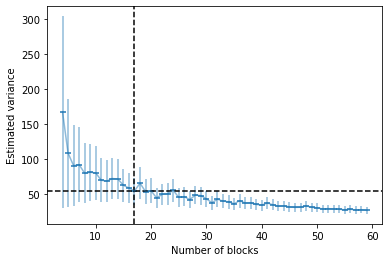

In [9]:
apo_ns = [17, 17, 17, 17, 17, 17, 17, 17, 17]
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    print(d)
    estimate_var(xs, maxn=60, chosen_n=n)

## C1P CPTP

5.0


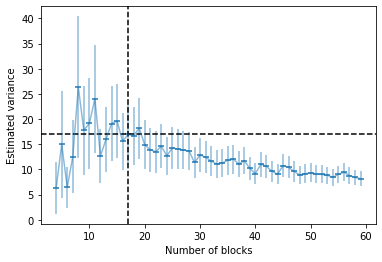

10.0


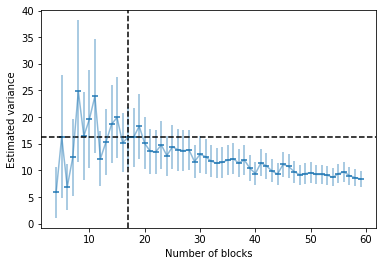

15.0


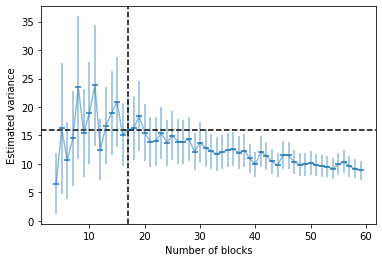

20.0


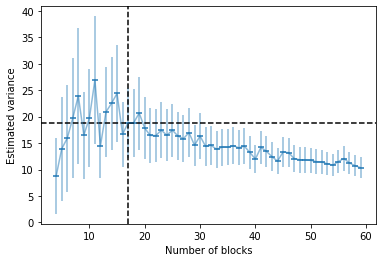

25.0


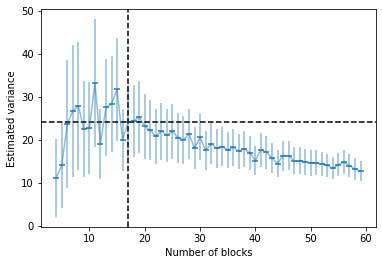

30.0


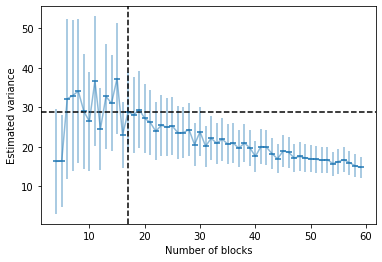

35.0


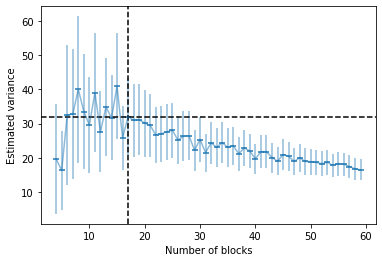

40.0


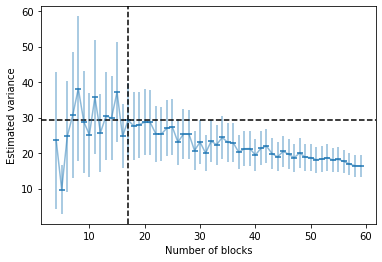

45.0


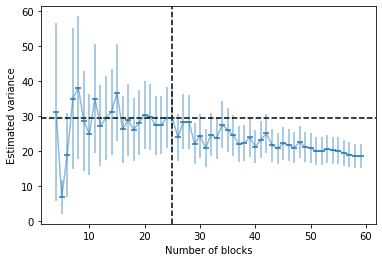

In [10]:
c1p_ns = [17, 17, 17, 17, 17, 17, 17, 17, 25]
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    print(d)
    estimate_var(xs, maxn=60, chosen_n=n)

## p-values: calculated with Welch's t-test

In [11]:
print("apo CPTP")
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))
    
print("C1P CPTP")
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))
    
print("Comparing apo CPTP to C1P CPTP")
for d, apo_xs, apo_n, c1p_xs, c1p_n in zip(dgrid[1:], apos, apo_ns, c1ps, c1p_ns):
    apo_samples = block_average(apo_xs, apo_n)
    c1p_samples = block_average(c1p_xs, c1p_n)
    t, p = stats.ttest_ind(apo_samples, c1p_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))

apo CPTP
p-value for radial distances ending at 5 ang:  2.6e-09 **
p-value for radial distances ending at 10 ang:  1.1e-07 **
p-value for radial distances ending at 15 ang:  1.4e-05 **
p-value for radial distances ending at 20 ang:    0.012 
p-value for radial distances ending at 25 ang:      0.4 
p-value for radial distances ending at 30 ang:     0.83 
p-value for radial distances ending at 35 ang:     0.33 
p-value for radial distances ending at 40 ang:     0.16 
p-value for radial distances ending at 45 ang:     0.15 
C1P CPTP
p-value for radial distances ending at 5 ang:  4.9e-07 **
p-value for radial distances ending at 10 ang:    3e-06 **
p-value for radial distances ending at 15 ang:  4.4e-05 **
p-value for radial distances ending at 20 ang:  0.00045 **
p-value for radial distances ending at 25 ang:   0.0043 *
p-value for radial distances ending at 30 ang:    0.026 
p-value for radial distances ending at 35 ang:    0.068 
p-value for radial distances ending at 40 ang:    0.098 


# $cos(\theta_z)$

In [149]:
# load for POPC membrane w/o protein
f = os.path.join(popc_dir, "memlip_costhetaz_100_300ns_mem.txt")
popc = np.loadtxt(f, usecols=(0,2,3))
popc = np.c_[popc[:,0], np.mean(popc[:,1:], axis=1)]
avpopc = time_av(popc[:,0], popc[:,1])

# load for CPTP apo
fr = os.path.join(apo_dir, "lip_com_radial_dist_100_300ns_protmem.txt")
rs = np.loadtxt(fr, usecols=(4,))
f = os.path.join(apo_dir, "memlip_costhetaz_100_300ns_protmem.txt")
apo = np.loadtxt(f, usecols=(0,3,4))
apo = np.c_[apo[:,0], np.mean(apo[:,1:], axis=1)]
apo = np.c_[apo,rs]
apos = radial_time_av(apo)

# load for CPTP C1P-bound
fr = os.path.join(c1p_dir, "lip_com_radial_dist_100_300ns_protmem.txt")
rs = np.loadtxt(fr, usecols=(4,))
f = os.path.join(c1p_dir, "memlip_costhetaz_100_300ns_protmem.txt")
c1p = np.loadtxt(f, usecols=(0,3,4))
c1p = np.c_[c1p[:,0], np.mean(c1p[:,1:], axis=1)]
c1p = np.c_[c1p,rs]
c1ps = radial_time_av(c1p)

## POPC membrane

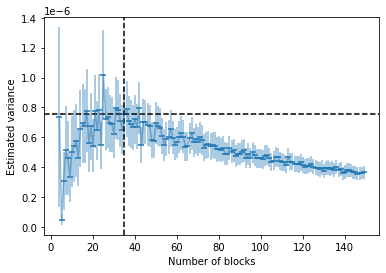

In [150]:
n = 35
estimate_var(avpopc, chosen_n=n, maxn=150)
popc_samples = block_average(avpopc, n)

## apo CPTP

5.0


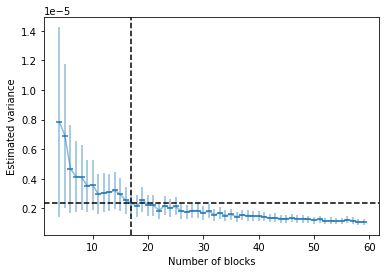

10.0


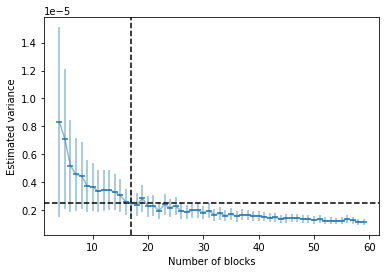

15.0


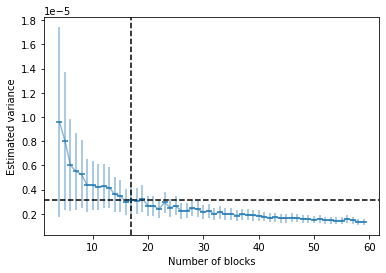

20.0


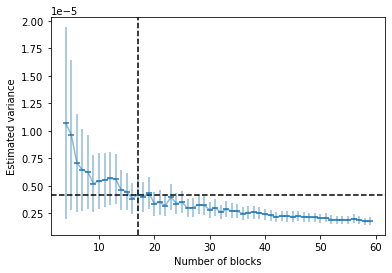

25.0


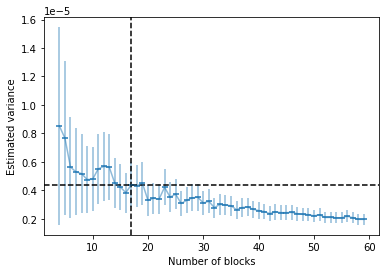

30.0


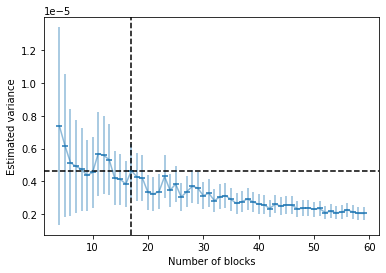

35.0


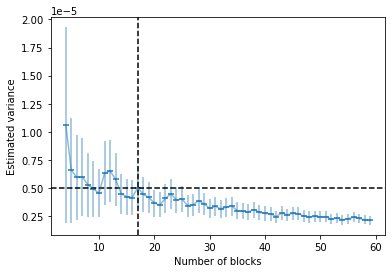

40.0


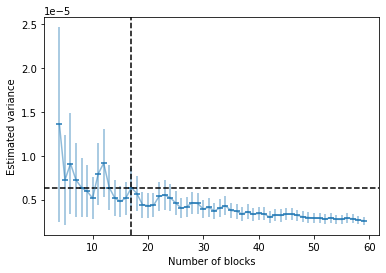

45.0


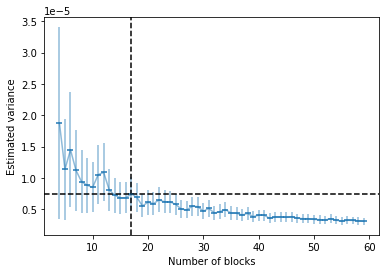

In [151]:
apo_ns = [17, 17, 17, 17, 17, 17, 17, 17, 17]
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    print(d)
    estimate_var(xs, maxn=60, chosen_n=n)

## C1P CPTP

5.0


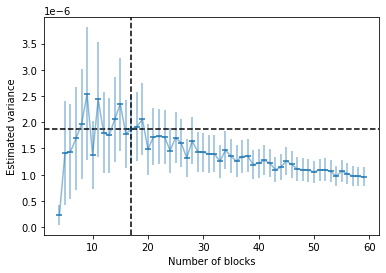

10.0


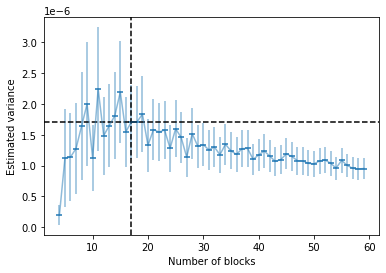

15.0


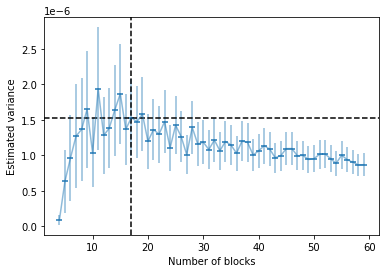

20.0


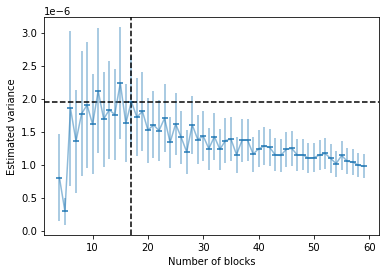

25.0


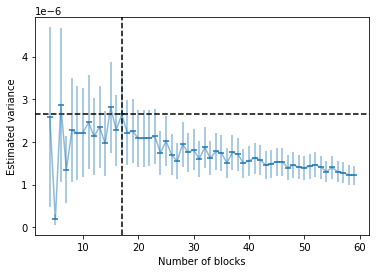

30.0


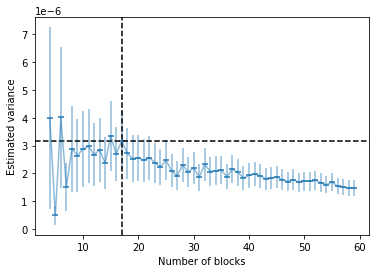

35.0


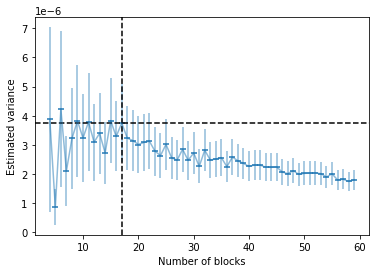

40.0


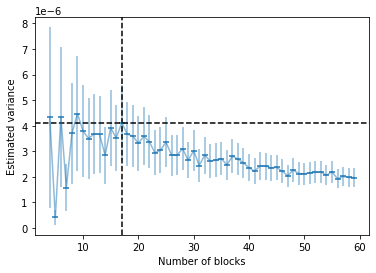

45.0


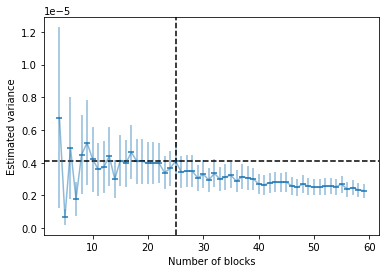

In [152]:
c1p_ns = [17, 17, 17, 17, 17, 17, 17, 17, 25]
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    print(d)
    estimate_var(xs, maxn=60, chosen_n=n)

## p-values: calculated with Welch's t-test

In [157]:
print("apo CPTP")
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))
    
print("C1P CPTP")
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))

apo CPTP
p-value for radial distances ending at 5 ang:   0.0007 **
p-value for radial distances ending at 10 ang:   0.0079 *
p-value for radial distances ending at 15 ang:     0.14 
p-value for radial distances ending at 20 ang:     0.78 
p-value for radial distances ending at 25 ang:     0.16 
p-value for radial distances ending at 30 ang:    0.043 
p-value for radial distances ending at 35 ang:    0.021 
p-value for radial distances ending at 40 ang:    0.041 
p-value for radial distances ending at 45 ang:    0.084 
C1P CPTP
p-value for radial distances ending at 5 ang:  1.5e-08 **
p-value for radial distances ending at 10 ang:  1.4e-06 **
p-value for radial distances ending at 15 ang:  0.00015 **
p-value for radial distances ending at 20 ang:   0.0071 *
p-value for radial distances ending at 25 ang:    0.067 
p-value for radial distances ending at 30 ang:     0.14 
p-value for radial distances ending at 35 ang:     0.14 
p-value for radial distances ending at 40 ang:     0.31 
p-val

# $S_{\rm CC}$

In [230]:
# load for POPC membrane w/o protein
f = os.path.join(popc_dir, "memlip_scc_100_300ns_mem.txt")
popc = np.loadtxt(f, usecols=(0,2))
avpopc = time_av(popc[:,0], popc[:,1])

# load for CPTP apo
fr = os.path.join(apo_dir, "lip_com_radial_dist_100_300ns_protmem.txt")
rs = np.loadtxt(fr, usecols=(4,))
f = os.path.join(apo_dir, "memlip_scc_100_300ns_protmem.txt")
apo = np.loadtxt(f, usecols=(0,2))
apo = np.c_[apo,rs]
apos = radial_time_av(apo)

# load for CPTP C1P-bound
fr = os.path.join(c1p_dir, "lip_com_radial_dist_100_300ns_protmem.txt")
rs = np.loadtxt(fr, usecols=(4,))
f = os.path.join(c1p_dir, "memlip_scc_100_300ns_protmem.txt")
c1p = np.loadtxt(f, usecols=(0,2))
c1p = np.c_[c1p,rs]
c1ps = radial_time_av(c1p)

## POPC membrane

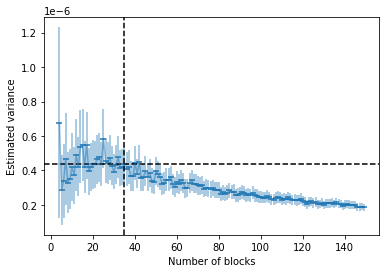

In [231]:
n = 35
estimate_var(avpopc, chosen_n=n, maxn=150)
popc_samples = block_average(avpopc, n)

## apo CPTP

5.0


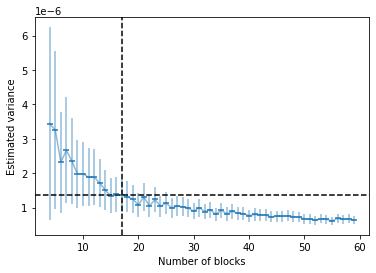

10.0


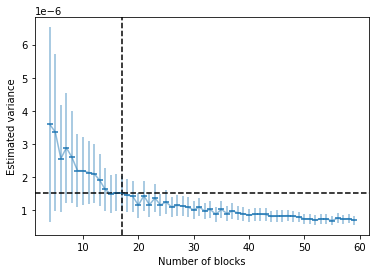

15.0


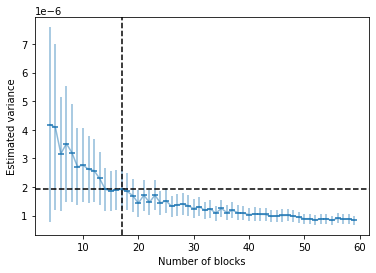

20.0


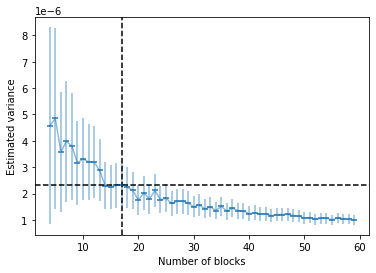

25.0


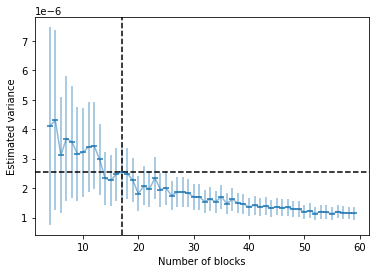

30.0


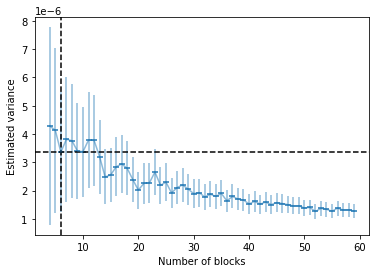

35.0


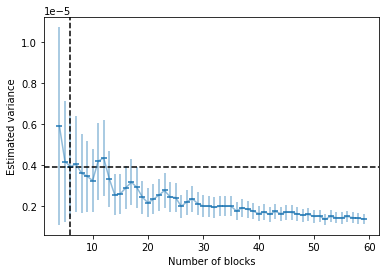

40.0


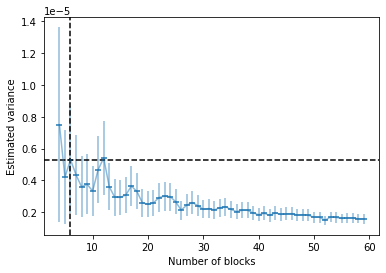

45.0


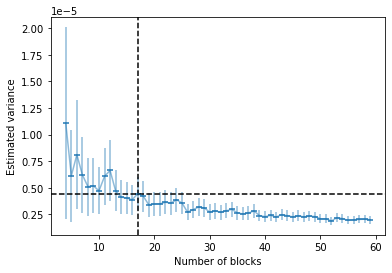

In [232]:
apo_ns = [17, 17, 17, 17, 17, 6, 6, 6, 17]
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    print(d)
    estimate_var(xs, maxn=60, chosen_n=n)

## C1P CPTP

5.0


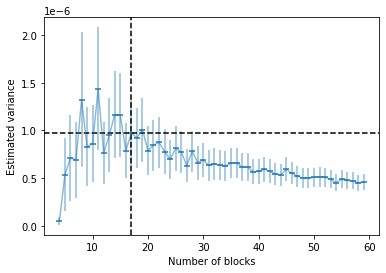

10.0


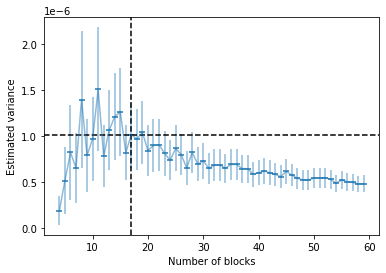

15.0


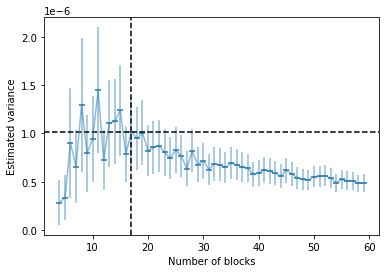

20.0


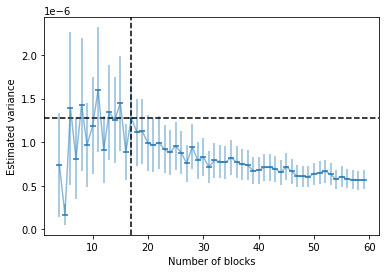

25.0


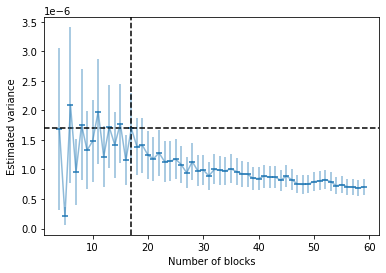

30.0


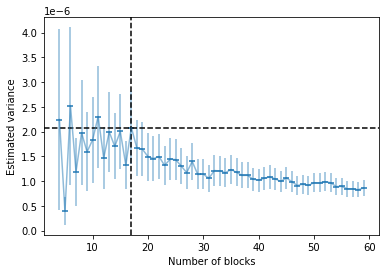

35.0


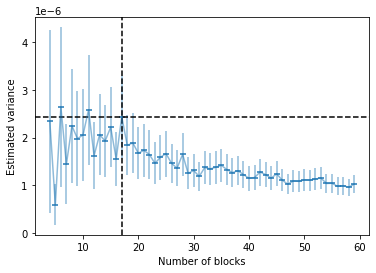

40.0


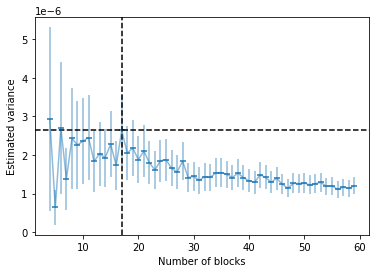

45.0


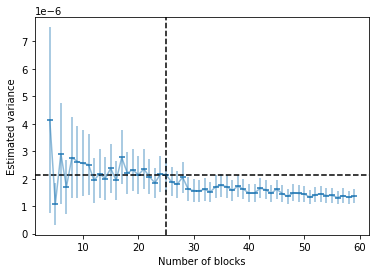

In [233]:
c1p_ns = [17, 17, 17, 17, 17, 17, 17, 17, 25]
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    print(d)
    estimate_var(xs, maxn=60, chosen_n=n)

## p-values: calculated with Welch's t-test

In [234]:
print("apo CPTP")
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))
    
print("C1P CPTP")
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))

apo CPTP
p-value for radial distances ending at 5 ang:    0.044 
p-value for radial distances ending at 10 ang:     0.18 
p-value for radial distances ending at 15 ang:     0.67 
p-value for radial distances ending at 20 ang:     0.29 
p-value for radial distances ending at 25 ang:    0.042 
p-value for radial distances ending at 30 ang:    0.028 
p-value for radial distances ending at 35 ang:    0.015 
p-value for radial distances ending at 40 ang:    0.017 
p-value for radial distances ending at 45 ang:     0.02 
C1P CPTP
p-value for radial distances ending at 5 ang:  1.1e-05 **
p-value for radial distances ending at 10 ang:  0.00023 **
p-value for radial distances ending at 15 ang:   0.0053 *
p-value for radial distances ending at 20 ang:    0.062 
p-value for radial distances ending at 25 ang:     0.25 
p-value for radial distances ending at 30 ang:     0.48 
p-value for radial distances ending at 35 ang:     0.61 
p-value for radial distances ending at 40 ang:     0.86 
p-value fo

# $A_{\rm lip}$

In [235]:
# load for POPC membrane w/o protein
f = os.path.join(popc_dir, "aplfatslim.txt")
popc = np.loadtxt(f, usecols=(0,2))
avpopc = time_av(popc[:,0], popc[:,1])

# load for CPTP apo
fr = os.path.join(apo_dir, "lip_com_radial_dist_100_300ns_protmem.txt")
rs = np.loadtxt(fr, usecols=(4,))
f = os.path.join(apo_dir, "aplfatslim.txt")
apo = np.loadtxt(f, usecols=(0,2))
apo = np.c_[apo,rs]
apos = radial_time_av(apo)

# load for CPTP C1P-bound
fr = os.path.join(c1p_dir, "lip_com_radial_dist_100_300ns_protmem.txt")
rs = np.loadtxt(fr, usecols=(4,))
f = os.path.join(c1p_dir, "aplfatslim.txt")
c1p = np.loadtxt(f, usecols=(0,2))
c1p = np.c_[c1p,rs]
c1ps = radial_time_av(c1p)

## POPC membrane

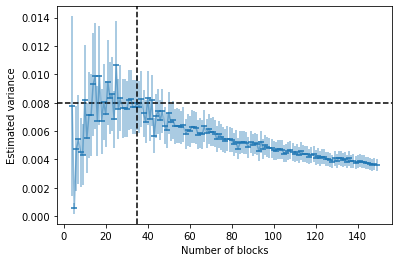

In [236]:
n = 35
estimate_var(avpopc, chosen_n=n, maxn=150)
popc_samples = block_average(avpopc, n)

## apo CPTP

5.0 66.34986267126851 65.30147641630249


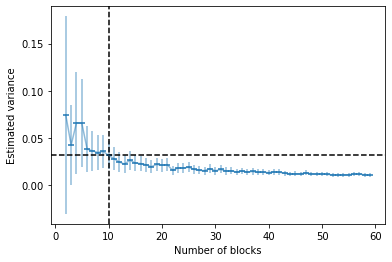

10.0 66.10824177012171 65.30147641630249


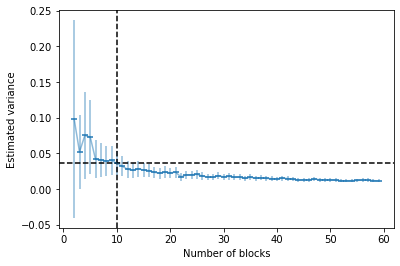

15.0 65.90013888373595 65.30147641630249


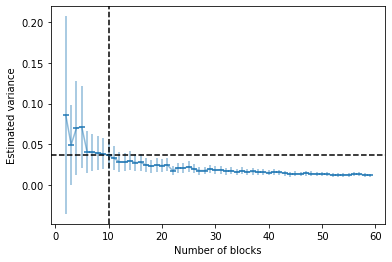

20.0 65.47961710385123 65.30147641630249


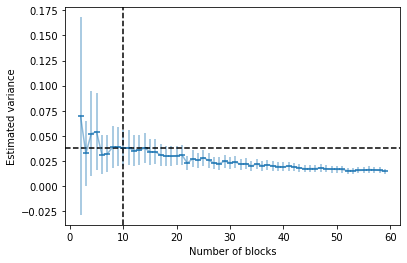

25.0 65.02298724296648 65.30147641630249


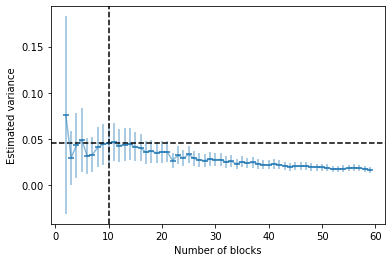

30.0 64.76100290076387 65.30147641630249


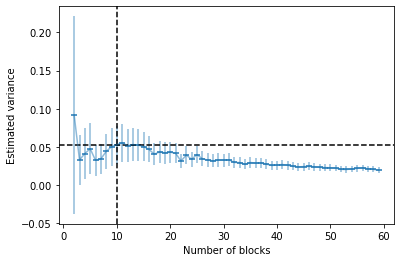

35.0 64.63175061559723 65.30147641630249


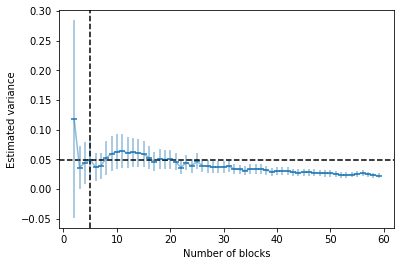

40.0 64.62767531380716 65.30147641630249


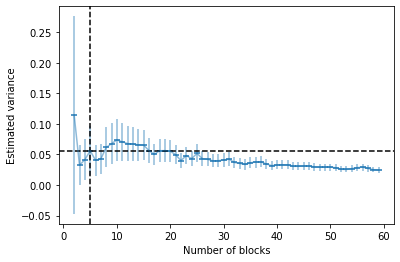

45.0 64.68894931841407 65.30147641630249


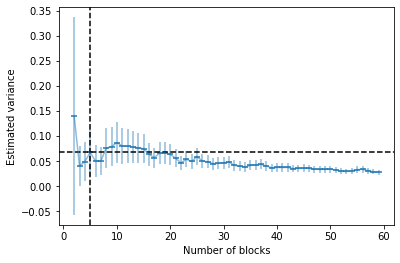

In [253]:
apo_ns = [10, 10, 10, 10, 10, 10, 5, 5, 5]
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    print(d, np.mean(xs), np.mean(popc_samples))
    estimate_var(xs, minn=2, maxn=60, chosen_n=n)

## C1P CPTP

5.0 65.60913905553804 65.30147641630249


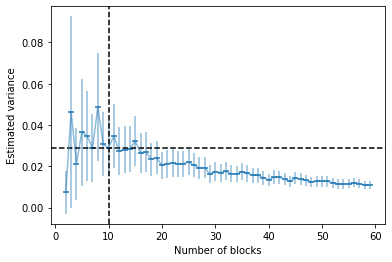

10.0 65.47542909956857 65.30147641630249


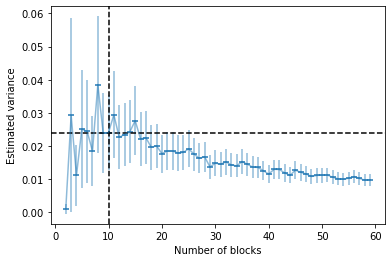

15.0 65.17406626960937 65.30147641630249


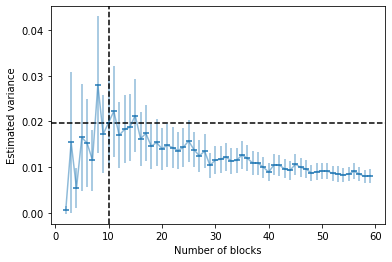

20.0 64.8523788541073 65.30147641630249


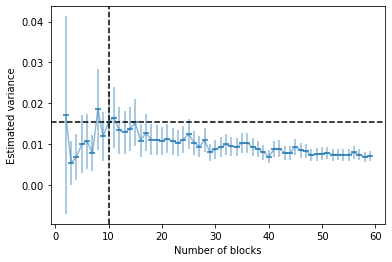

25.0 64.64265403604696 65.30147641630249


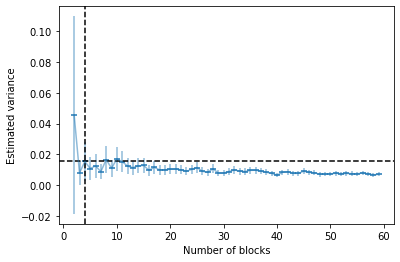

30.0 64.56713129886403 65.30147641630249


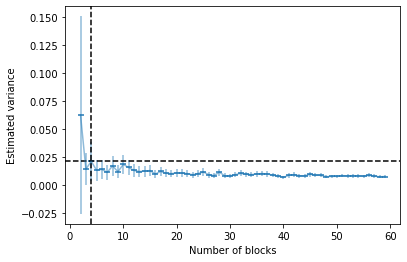

35.0 64.57445533623674 65.30147641630249


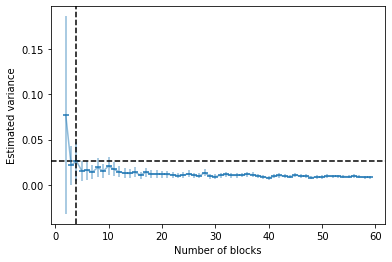

40.0 64.60471392209054 65.30147641630249


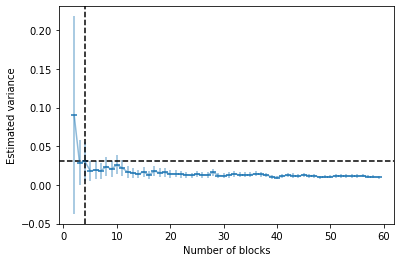

45.0 64.64791959822428 65.30147641630249


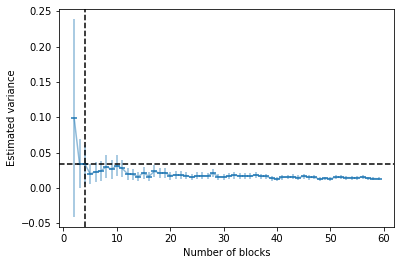

In [249]:
c1p_ns = [10, 10, 10, 10, 4, 4, 4, 4, 4]
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    print(d, np.mean(xs), np.mean(popc_samples))
    estimate_var(xs, minn=2, maxn=60, chosen_n=n)

## p-values: calculated with Welch's t-test

In [254]:
print("apo CPTP")
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))
    
print("C1P CPTP")
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))

apo CPTP
p-value for radial distances ending at 5 ang:  2.2e-06 **
p-value for radial distances ending at 10 ang:  0.00016 **
p-value for radial distances ending at 15 ang:   0.0038 *
p-value for radial distances ending at 20 ang:     0.37 
p-value for radial distances ending at 25 ang:     0.17 
p-value for radial distances ending at 30 ang:    0.012 
p-value for radial distances ending at 35 ang:    0.011 
p-value for radial distances ending at 40 ang:    0.011 
p-value for radial distances ending at 45 ang:    0.022 
C1P CPTP
p-value for radial distances ending at 5 ang:     0.11 
p-value for radial distances ending at 10 ang:     0.36 
p-value for radial distances ending at 15 ang:     0.49 
p-value for radial distances ending at 20 ang:    0.017 
p-value for radial distances ending at 25 ang:     0.02 
p-value for radial distances ending at 30 ang:     0.01 
p-value for radial distances ending at 35 ang:    0.011 
p-value for radial distances ending at 40 ang:    0.015 
p-value fo

# Thickness

In [211]:
# load for POPC membrane w/o protein
f = os.path.join(popc_dir, "mem_thickness_100_300ns_mem.txt")
avpopc = np.loadtxt(f, usecols=(1,))

# load for CPTP apo
f = os.path.join(apo_dir, "memlip_thickness_radial_100_300ns_protmem.txt")
apo = np.loadtxt(f)
apos = [time_av(apo[:,0], apo[:,i]) for i in range(1,apo.shape[1])]

# load for CPTP C1P-bound
f = os.path.join(c1p_dir, "memlip_thickness_radial_100_300ns_protmem.txt")
c1p = np.loadtxt(f)
c1ps = [time_av(c1p[:,0], c1p[:,i]) for i in range(1,c1p.shape[1])]

## POPC membrane

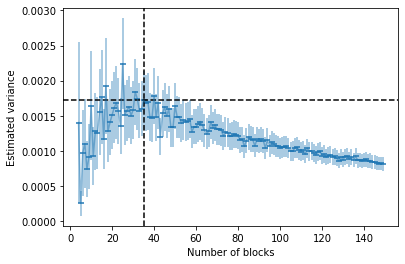

In [228]:
n = 35
estimate_var(avpopc, chosen_n=n, maxn=150)
popc_samples = block_average(avpopc, n)

## apo CPTP

5.0 35.42850686608375 38.830846179083615


/var/folders/p9/cnxldg9x2x75bc1nl5r39c7w0000gn/T/ipykernel_61058/2692231242.py:3: RuntimeWarning: Mean of empty slice
  block_avs = list(map(np.nanmean, split_xs))


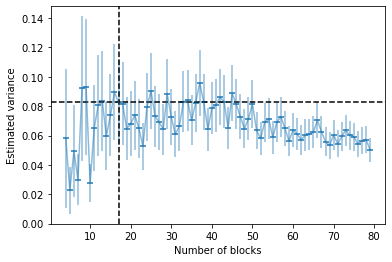

10.0 36.727111094166986 38.830846179083615


/var/folders/p9/cnxldg9x2x75bc1nl5r39c7w0000gn/T/ipykernel_61058/2692231242.py:3: RuntimeWarning: Mean of empty slice
  block_avs = list(map(np.nanmean, split_xs))


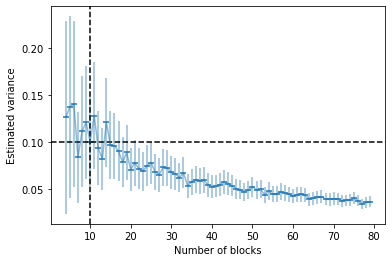

15.0 36.58122320222913 38.830846179083615


/var/folders/p9/cnxldg9x2x75bc1nl5r39c7w0000gn/T/ipykernel_61058/2692231242.py:3: RuntimeWarning: Mean of empty slice
  block_avs = list(map(np.nanmean, split_xs))


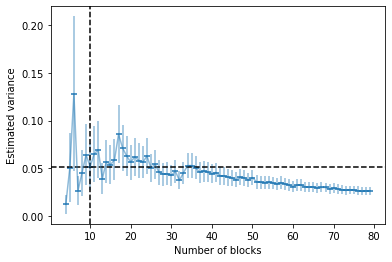

20.0 37.03741692486649 38.830846179083615


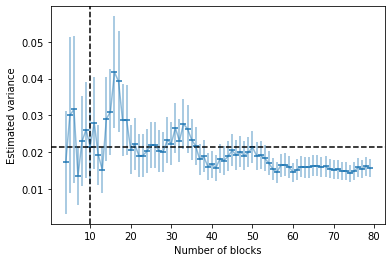

25.0 38.08124725508037 38.830846179083615


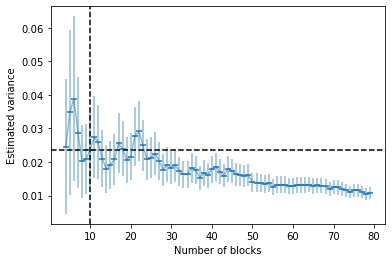

30.0 38.23909832923586 38.830846179083615


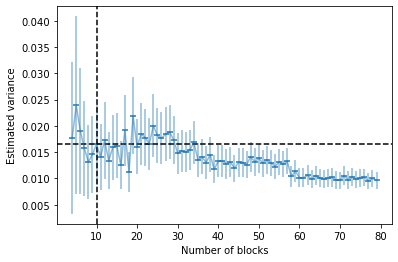

35.0 38.392853067346635 38.830846179083615


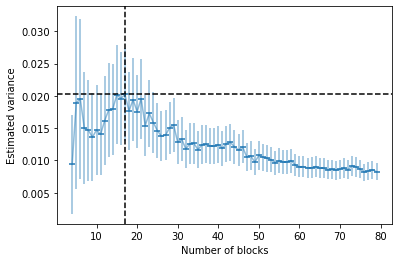

40.0 38.697189660516976 38.830846179083615


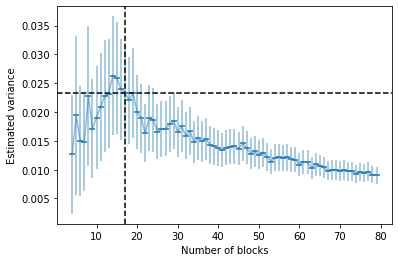

45.0 38.83725307734613 38.830846179083615


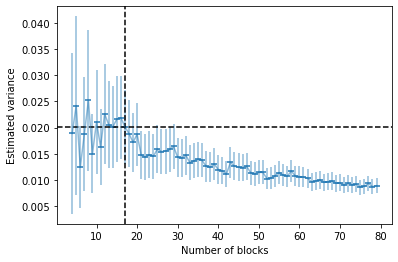

In [216]:
apo_ns = [17, 10, 10, 10, 10, 10, 17, 17, 17]
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    print(d, np.nanmean(xs), np.mean(popc_samples))
    estimate_var(xs, maxn=80, chosen_n=n)

## C1P CPTP

5.0 34.604040404040404 38.830846179083615


/var/folders/p9/cnxldg9x2x75bc1nl5r39c7w0000gn/T/ipykernel_61058/2692231242.py:3: RuntimeWarning: Mean of empty slice
  block_avs = list(map(np.nanmean, split_xs))


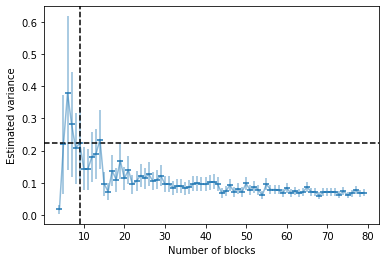

10.0 36.46302452046035 38.830846179083615


/var/folders/p9/cnxldg9x2x75bc1nl5r39c7w0000gn/T/ipykernel_61058/2692231242.py:3: RuntimeWarning: Mean of empty slice
  block_avs = list(map(np.nanmean, split_xs))


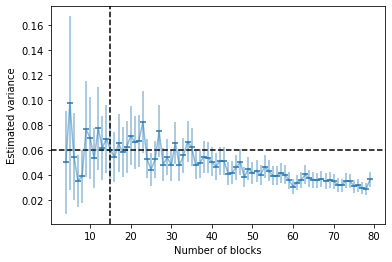

15.0 37.43293623562544 38.830846179083615


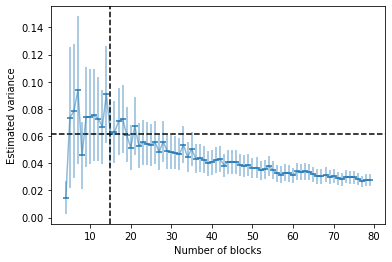

20.0 37.88162989341085 38.830846179083615


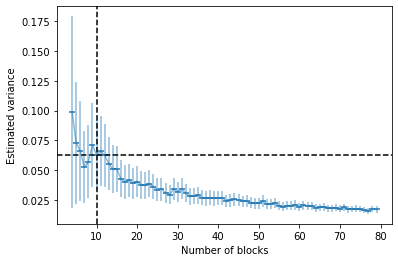

25.0 37.968692372145306 38.830846179083615


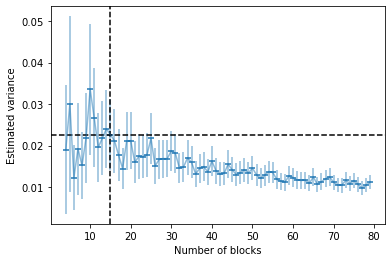

30.0 38.17121773035401 38.830846179083615


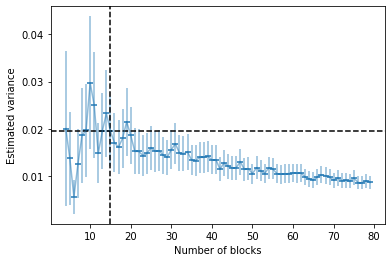

35.0 38.48036394551009 38.830846179083615


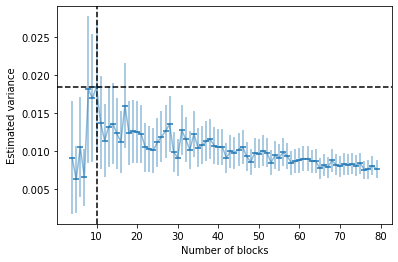

40.0 38.72129823920764 38.830846179083615


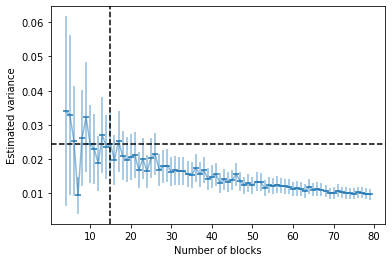

45.0 38.93232125425086 38.830846179083615


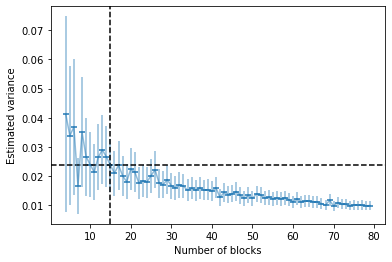

In [224]:
c1p_ns = [9, 15, 15, 10, 15, 15, 10, 15, 15]
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    print(d, np.nanmean(xs), np.mean(popc_samples))
    estimate_var(xs, maxn=80, chosen_n=n)

## p-values: calculated with Welch's t-test

In [229]:
print("apo CPTP")
for d, xs, n in zip(dgrid[1:], apos, apo_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))
    
print("C1P CPTP")
for d, xs, n in zip(dgrid[1:], c1ps, c1p_ns):
    samples = block_average(xs, n)
    t, p = stats.ttest_ind(samples, popc_samples)
    if p < 0.001: ann = '**'
    elif p < 0.01: ann = '*'
    else: ann = ''
    print("p-value for radial distances ending at %.0f ang: %8.2g %s" % (d, p, ann))

apo CPTP
p-value for radial distances ending at 5 ang:  3.7e-22 **
p-value for radial distances ending at 10 ang:  2.7e-14 **
p-value for radial distances ending at 15 ang:  8.1e-20 **
p-value for radial distances ending at 20 ang:  2.3e-20 **
p-value for radial distances ending at 25 ang:  2.5e-08 **
p-value for radial distances ending at 30 ang:  7.5e-07 **
p-value for radial distances ending at 35 ang:  0.00038 **
p-value for radial distances ending at 40 ang:     0.28 
p-value for radial distances ending at 45 ang:     0.96 
C1P CPTP
p-value for radial distances ending at 5 ang:  6.4e-23 **
p-value for radial distances ending at 10 ang:  3.4e-18 **
p-value for radial distances ending at 15 ang:  2.3e-10 **
p-value for radial distances ending at 20 ang:    1e-07 **
p-value for radial distances ending at 25 ang:  1.7e-09 **
p-value for radial distances ending at 30 ang:  2.7e-07 **
p-value for radial distances ending at 35 ang:   0.0018 *
p-value for radial distances ending at 40 ang